# Robustness to noise
Compare model with local neighborhood to model without neighborhood.

Predict latent representation of test/val? set by adding different levels of noise to the input (gaussian noise). 

Evaluations:
- Compare how much the latent representation differs from the original one (GT).

Expectation:
- model with neighborhood is more robust to noise

also see fig1_suppl_cluster_subsampling, which does a similar thing, but for subsampling variability. Here, we can choose a random subset of the data to compute noise variability on, we don't need to look at the entire dataset!

In [1]:
from campa.constants import campa_config
from campa.data import MPPData
from campa.tl import Experiment, Predictor
from campa.tl import Cluster
from campa.tl._cluster import add_clustering_to_adata
from campa.pl import annotate_img
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
import os
import numpy as np
import scanpy as sc

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'plotting' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig1_suppl'
os.makedirs(str(fig_dir), exist_ok=True)

In [4]:
# load models to compare
exp_name = 'VAE_all/CondVAE_pert-CC'
exp_name_noneigh = 'VAE_all/CondVAE_pert-CC_noneigh'

pred = Predictor(Experiment.from_dir(exp_name))
pred_noneigh = Predictor(Experiment.from_dir(exp_name_noneigh))

2022-01-27 09:29:25.269250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# get data to evaluate on
mpp_data = MPPData.from_data_dir(f'{exp_name}/aggregated/sub-0.001', optional_keys=['mpp', 'latent', 'conditions'], base_dir=campa_config.EXPERIMENT_DIR)

In [8]:
print(mpp_data.mpp.shape)

(154906, 3, 3, 34)


## Predict latent with different noise levels
- on subset of data used for clustering

In [31]:
# predict X and noisy X for the two models
scales = np.arange(0,0.2,0.025)
results = []
for scale in scales:
    for exp_name in ['VAE_all/CondVAE_pert-CC', 'VAE_all/CondVAE_pert-CC_noneigh']:
        for seed in [0,1,2,3,4]:
            print(scale, exp_name, seed)
            rng = np.random.default_rng(seed=seed)
            noise = rng.normal(loc=0, scale=scale, size=mpp_data.mpp.shape)
            if 'noneigh' in exp_name:
                data = [(mpp_data.mpp+noise)[:,1:2,1:2,:], mpp_data.conditions]
                latent_noisy = pred_noneigh.est.model.encoder.predict(data, batch_size=pred.batch_size)
                latent = latent_cVAE_noneigh
            else:
                data = [mpp_data.mpp+noise, mpp_data.conditions]
                latent_noisy = pred.est.model.encoder.predict(data, batch_size=pred.batch_size)
                latent = latent_cVAE
            
            # calculate mse and mae between latent and latent noisy
            mse = np.sqrt(np.mean((latent - latent_noisy)**2))
            mae = np.mean(np.abs(latent - latent_noisy))
            results.append({'exp_name':exp_name, 'scale': scale, 'seed': seed, 'mse': mse, 'mae': mae})

results = pd.DataFrame(results)
results.to_csv(fig_dir/'noise_robustness.csv')

0.0 VAE_all/CondVAE_pert-CC 0
0.0 VAE_all/CondVAE_pert-CC 1
0.0 VAE_all/CondVAE_pert-CC 2
0.0 VAE_all/CondVAE_pert-CC 3
0.0 VAE_all/CondVAE_pert-CC 4
0.0 VAE_all/CondVAE_pert-CC_noneigh 0
0.0 VAE_all/CondVAE_pert-CC_noneigh 1
0.0 VAE_all/CondVAE_pert-CC_noneigh 2
0.0 VAE_all/CondVAE_pert-CC_noneigh 3
0.0 VAE_all/CondVAE_pert-CC_noneigh 4
0.025 VAE_all/CondVAE_pert-CC 0
0.025 VAE_all/CondVAE_pert-CC 1
0.025 VAE_all/CondVAE_pert-CC 2
0.025 VAE_all/CondVAE_pert-CC 3
0.025 VAE_all/CondVAE_pert-CC 4
0.025 VAE_all/CondVAE_pert-CC_noneigh 0
0.025 VAE_all/CondVAE_pert-CC_noneigh 1
0.025 VAE_all/CondVAE_pert-CC_noneigh 2
0.025 VAE_all/CondVAE_pert-CC_noneigh 3
0.025 VAE_all/CondVAE_pert-CC_noneigh 4
0.05 VAE_all/CondVAE_pert-CC 0
0.05 VAE_all/CondVAE_pert-CC 1
0.05 VAE_all/CondVAE_pert-CC 2
0.05 VAE_all/CondVAE_pert-CC 3
0.05 VAE_all/CondVAE_pert-CC 4
0.05 VAE_all/CondVAE_pert-CC_noneigh 0
0.05 VAE_all/CondVAE_pert-CC_noneigh 1
0.05 VAE_all/CondVAE_pert-CC_noneigh 2
0.05 VAE_all/CondVAE_pert-CC

## Plot results

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(os.path.join(fig_dir, 'noise_robustness.csv'), index_col=0)

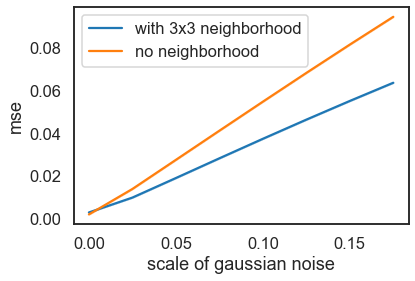

In [5]:
sns.set_style('white')
sns.set_context('talk')

sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC'], x='scale', y='mse', ci=95, 
             label='with 3x3 neighborhood')
g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_noneigh'], x='scale', y='mse', 
                 ci=95, label='no neighborhood')
g.set_xlabel('scale of gaussian noise')
plt.savefig(os.path.join(fig_dir, 'noise_robustness.png'), bbox_inches='tight', dpi=300)

In [ ]:
df

,exp_name,scale,seed,mse,mae
0,VAE_all/CondVAE_pert-CC,0.000,0,0.002856,0.002260
1,VAE_all/CondVAE_pert-CC,0.000,1,0.002855,0.002259
2,VAE_all/CondVAE_pert-CC,0.000,2,0.002856,0.002258
3,VAE_all/CondVAE_pert-CC,0.000,3,0.002858,0.002261
4,VAE_all/CondVAE_pert-CC,0.000,4,0.002855,0.002259
...,...,...,...,...,...
75,VAE_all/CondVAE_pert-CC_noneigh,0.175,0,0.094599,0.075173
76,VAE_all/CondVAE_pert-CC_noneigh,0.175,1,0.094552,0.075158
77,VAE_all/CondVAE_pert-CC_noneigh,0.175,2,0.094592,0.075173
78,VAE_all/CondVAE_pert-CC_noneigh,0.175,3,0.094547,0.075166
